# Demo : full method tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))
from src.config import setup_logging
logger = setup_logging("DEBUG")

from src.data.data_utils import load_data, num_to_data_path, train_test_split, stack_and_scale
from src.data.preprocessing import bin_to_pm1, add_bias, init_wv, pad_to_pow2_cols, pad_to_pow2_rows
from src.data.scalers import MaxAbsScaler, MinMaxScaler, StandardScaler

from src.sigmoid import get_sigmoid_approx
from src.nag_momentum import NAGUpdater

from src.models.logreg_ct import LogisticRegression
from src.metrics import (
    print_classification_metrics, 
    calculate_acc_auc_idash_style, 
    beta_to_loss_history, 
    plot_loss_evolution, 
    plot_proba_distrib
)

from src.encryption import (
    init_ckks, 
    encode_encrypt_beta, 
    encode_encrypt_features,
    decrypt_decode_matrix
)

In [2]:
# Parameters
dataset_num = 3

n_epoch = 7
gamma_up = 10
gamma_down = -1

use_nag = True
scaler = MaxAbsScaler()     # MaxAbsScaler(), MinMaxScaler(), StandardScaler()
beta_init_method = "mean-idash"   # mean, zero, random
nag_smooth_method = NAGUpdater('idash')

degree = 5  # 3, 5, 7
true_sigmoid = get_sigmoid_approx()
minus_sigmoid = get_sigmoid_approx("minus_sigmoid")
sigmoid = get_sigmoid_approx("least_squares", degree=degree, encrypted=True)

mult_depth = int(n_epoch * (7 + ((degree-3)/2))) + 5

DEBUG - Getting sigmoid approximation: method=sigmoid, degree=0, encrypted=False
DEBUG - Getting sigmoid approximation: method=minus_sigmoid, degree=0, encrypted=False
DEBUG - Getting sigmoid approximation: method=least_squares, degree=5, encrypted=True


## Load data and preprocessing

In [3]:
X, y_bin = load_data(num_to_data_path(dataset_num))

INFO - Loading data from ../data/lbw.txt
INFO - Loaded dataset with 189 samples and 9 features


In [4]:
# iDASH
X_train, X_test, y_bin_train, y_bin_test = train_test_split(X, y_bin, test_size=0.2)

Z_train_ = bin_to_pm1(y_bin_train)[:, np.newaxis] * add_bias(X_train)
Z_test_ = bin_to_pm1(y_bin_test)[:, np.newaxis] * add_bias(X_test)

Z_train, Z_test = stack_and_scale(scaler, Z_train_, Z_test_)

w, v = init_wv(Z_train, method=beta_init_method)

INFO - Splitting data into train/test sets
DEBUG - Train size: 151, Test size: 38
INFO - Adding bias term
DEBUG - Added bias term: (151, 9) -> (151, 10)
INFO - Adding bias term
DEBUG - Added bias term: (38, 9) -> (38, 10)
INFO - Stacking and scaling data
DEBUG - Scaled rang: [-1.0, 1.0]
INFO - Initializing weights for 10 features as: 'mean-idash'
DEBUG - Weight stats - Min: -0.0001, Max: 0.0015, Mean: 0.0005


In [5]:
# # iDASH corrected
# X_ = add_bias(X)

# X_train, X_test, y_bin_train, y_bin_test = train_test_split(X_, y_bin, test_size=0.2)

# Z_train = scaler.fit_transform(X_train)
# Z_test = scaler.transform(X_test)

# Z_train = bin_to_pm1(y_bin_train)[:, np.newaxis] * Z_train

# w, v = init_wv(Z_train, method=beta_init_method)

In [ ]:
# Encode
Z_train_padded = pad_to_pow2_rows(pad_to_pow2_cols(Z_train))
Z_test_padded = pad_to_pow2_cols(Z_test)
# y_train = pad_to_pow2_rows(y_train[:, np.newaxis])[:, 0]

n, f_plus_1 = Z_train_padded.shape
f = f_plus_1 - 1
Z_dims = (n, f)

w_padded = pad_to_pow2_cols(w.reshape(1, -1))
w_padded = np.tile(w_padded, (Z_dims[0], 1))
v_padded = pad_to_pow2_cols(v.reshape(1, -1))
v_padded = np.tile(v_padded, (Z_dims[0], 1))

INFO - Padding columns: 10 -> 16 (next power of 2)
INFO - Padding rows: 151 -> 256 (next power of 2)
INFO - Padding columns: 10 -> 16 (next power of 2)
INFO - Padding columns: 10 -> 16 (next power of 2)
INFO - Padding columns: 10 -> 16 (next power of 2)


: 

## Encrypt

In [ ]:
# Initialize CKKS context
cc, key_pair, params = init_ckks(n, f, mult_depth=mult_depth)
public_key = key_pair.publicKey
secret_key = key_pair.secretKey

DEBUG - Initializing CKKS context
DEBUG - Input parameters: n=256, f=15, mult_depth=61
DEBUG - CKKS parameters: scheme: CKKSRNS; ptModulus: 0; digitSize: 0; standardDeviation: 3.19; secretKeyDist: UNIFORM_TERNARY; maxRelinSkDeg: 2; ksTech: HYBRID; scalTech: FLEXIBLEAUTOEXT; batchSize: 4096; firstModSize: 60; numLargeDigits: 0; multiplicativeDepth:61; scalingModSize: 30; securityLevel: HEStd_128_classic; ringDim: 0; evalAddCount: 0; keySwitchCount: 0; encryptionTechnique: STANDARD; multiplicationTechnique: HPS; PRENumHops: 0; PREMode: INDCPA; multipartyMode: FIXED_NOISE_MULTIPARTY; executionMode: EXEC_EVALUATION; decryptionNoiseMode: FIXED_NOISE_DECRYPT; noiseEstimate: 0; desiredPrecision: 25; statisticalSecurity: 30; numAdversarialQueries: 1; thresholdNumOfParties: 1; interactiveBootCompressionLevel: SLACK; compositeDegree: 1; registerWordSize: 64; ckksDataType: REAL


In [ ]:
# Encrypt features and beta
ct_w = encode_encrypt_beta(w_padded.flatten(), cc, public_key, n)
ct_v = encode_encrypt_beta(v_padded.flatten(), cc, public_key, n)
ct_Z_train, vec_length = encode_encrypt_features(Z_train_padded, cc, public_key)

DEBUG - Beta shape: (4096,), n: 256
INFO - Beta encrypted.
DEBUG - Beta shape: (4096,), n: 256
INFO - Beta encrypted.
DEBUG - Input shape: (256, 16)
DEBUG - Encrypted vector length: 4096
INFO - Features encrypted.


## Logistic regression

In [ ]:
model_no_nag = LogisticRegression(
    sigmoid=sigmoid,
    cc=cc,
    use_NAG=use_nag,
    nag_momentum_update=nag_smooth_method
)
model_no_nag.fit(
    ct_Z_train, Z_dims,
    ct_w,
    n_epoch=n_epoch,
    gamma_up=gamma_up,
    gamma_down=gamma_down,
    ct_v=ct_v
)

INFO - >>> Epoch 1 <<<
DEBUG - Learning rate: 5.0000 - Smoothing parameter: 0.0
DEBUG - Computing inner product
DEBUG - Mask created: length 4096
INFO - Inner product computed.
DEBUG - Computing aggregate gradient
INFO - Aggregate gradient computed.
DEBUG - Update beta
INFO - Beta updated.
DEBUG - Update v
INFO - v updated.
INFO - >>> Epoch 2 <<<
DEBUG - Learning rate: 3.3333 - Smoothing parameter: -0.28175352512532087
DEBUG - Computing inner product
DEBUG - Mask created: length 4096
INFO - Inner product computed.
DEBUG - Computing aggregate gradient
INFO - Aggregate gradient computed.
DEBUG - Update beta
INFO - Beta updated.
DEBUG - Update v
INFO - v updated.
INFO - >>> Epoch 3 <<<
DEBUG - Learning rate: 2.5000 - Smoothing parameter: -0.434042782780302
DEBUG - Computing inner product
DEBUG - Mask created: length 4096
INFO - Inner product computed.
DEBUG - Computing aggregate gradient
INFO - Aggregate gradient computed.
DEBUG - Update beta
INFO - Beta updated.
DEBUG - Update v
INFO - v

## Decrypt

In [ ]:
original_samples, original_features = add_bias(X_train).shape

ct_beta = model_no_nag.ct_beta
pt_beta = decrypt_decode_matrix(ct_beta, cc, secret_key, n * (f + 1), (n, f + 1))

ct_beta_history = model_no_nag.ct_beta_history
pt_beta_history = np.array([decrypt_decode_matrix(ct_beta_i, cc, secret_key, n * (f + 1), (n, f + 1)) for ct_beta_i in ct_beta_history])
pt_beta_history_depadded = np.array([beta[0][:original_features] for beta in pt_beta_history])

INFO - Adding bias term
DEBUG - Added bias term: (151, 9) -> (151, 10)
DEBUG - Output shape: (256, 16)
INFO - Matrix decrypted.
DEBUG - Output shape: (256, 16)
INFO - Matrix decrypted.
DEBUG - Output shape: (256, 16)
INFO - Matrix decrypted.
DEBUG - Output shape: (256, 16)
INFO - Matrix decrypted.


## Analysis

### Train

DEBUG - minus sigmoid output: [0.4990, 0.5010]
DEBUG - minus sigmoid output: [0.4990, 0.5010]
DEBUG - minus sigmoid output: [0.4990, 0.5009]
DEBUG - minus sigmoid output: [0.4990, 0.5010]


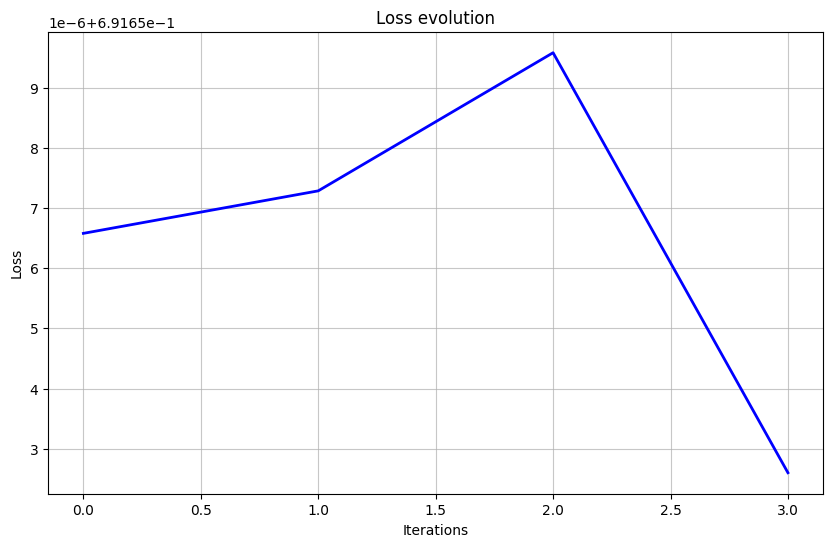

In [ ]:
beta_history = np.concatenate([[w], pt_beta_history_depadded])
loss_history = beta_to_loss_history(beta_history, Z_train, y_bin_train, minus_sigmoid)
plot_loss_evolution(loss_history)

### Test

In [ ]:
w_trained = pt_beta[0][:original_features]
proba = model_no_nag.predict_proba(Z_test, w_trained, sigmoid=minus_sigmoid)
print_classification_metrics(
    y_bin_test, proba
)

DEBUG - minus sigmoid output: [0.4990, 0.5009]



ACC: 1.0000
AUC: 1.0000
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00        26

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

[[12  0]
 [ 0 26]]

MSE: 0.0000
NMSE: 0.0000



(np.float64(1.0), 1.0)

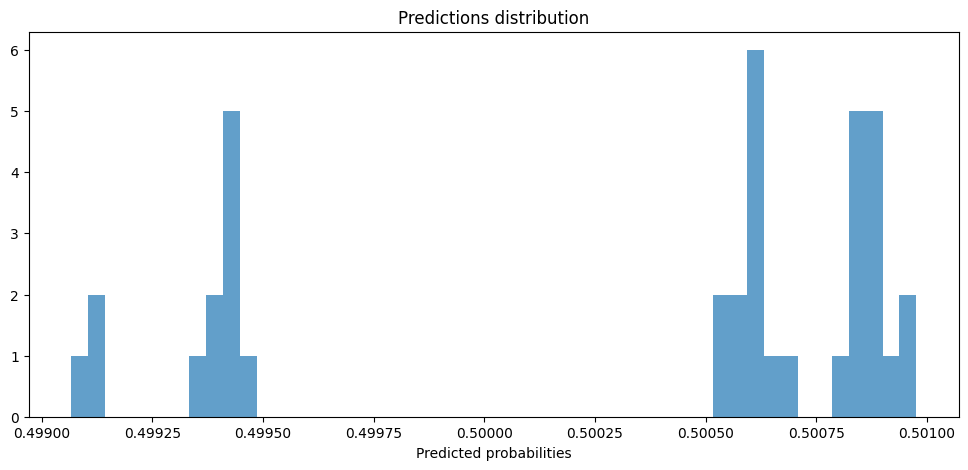

In [ ]:
plot_proba_distrib(proba)

In [ ]:
calculate_acc_auc_idash_style(Z_test, w_trained)

ACC: 68.4211 %.
AUC: 0.6538


(68.42105263157895, 0.6538461538461539)